In [42]:
import os
import numpy as np
from matplotlib import pyplot as plt
from time import time

In [43]:
from foxhound import (
    activations, updates, inits)
from foxhound.theano_utils import floatX, sharedX

In [44]:
import theano
import theano.tensor as T

In [45]:
from scipy.stats import gaussian_kde
from scipy.misc import imsave, imread

In [46]:
leakyrectify = activations.LeakyRectify()
rectify = activations.Rectify()
tanh = activations.Tanh()
sigmoid = activations.Sigmoid()

In [47]:
bce = T.nnet.binary_crossentropy
batch_size = 128
nh = 2048
init_fn = inits.Normal(scale=0.02)

In [48]:
def gaussian_likelihood(X, u=0., s=1.):
    return (1./(s*np.sqrt(2*np.pi)))*np.exp(-(((X - u)**2)/(2*s**2)))

In [49]:
def scale_and_shift(X, g, b, e=1e-8):
    X = X*g + b
    return X

In [50]:
def generator(X, w, g, b, w2, g2, b2, wo):
    h = leakyrectify(scale_and_shift(T.dot(X, w), g, b))
    h2 = leakyrectify(scale_and_shift(T.dot(h, w2), g2, b2))
    y = T.dot(h2, wo)
    return y

In [51]:
def discriminator(X, w, g, b, w2, g2, b2, wo):
    h = rectify(scale_and_shift(T.dot(X, w), g, b))
    h2 = tanh(scale_and_shift(T.dot(h, w2), g2, b2))
    y = sigmoid(T.dot(h2, wo))
    return y

In [52]:
gw = init_fn((1, nh))
gg = inits.Constant(1.)(nh)
gg = inits.Normal(1., 0.02)(nh)
gb = inits.Normal(0., 0.02)(nh)
gw2 = init_fn((nh, nh))
gg2 = inits.Normal(1., 0.02)(nh)
gb2 = inits.Normal(0., 0.02)(nh)
gy = init_fn((nh, 1))
ggy = inits.Constant(1.)(1)
gby = inits.Normal(0., 0.02)(1)
dw = init_fn((1, nh))
dg = inits.Normal(1., 0.02)(nh)
db = inits.Normal(0., 0.02)(nh)
dw2 = init_fn((nh, nh))
dg2 = inits.Normal(1., 0.02)(nh)
db2 = inits.Normal(0., 0.02)(nh)
dy = init_fn((nh, 1))
dgy = inits.Normal(1., 0.02)(1)
dby = inits.Normal(0., 0.02)(1)

In [53]:
g_params = [gw, gg, gb, gw2, gg2, gb2, gy]
d_params = [dw, dg, db, dw2, dg2, db2, dy]

In [54]:
Z = T.matrix()
X = T.matrix()

In [55]:
gen = generator(Z, *g_params)

In [56]:
p_real = discriminator(X, *d_params)
p_gen = discriminator(gen, *d_params)

In [57]:
d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
g_cost_d = bce(p_gen, T.ones(p_gen.shape)).mean()

In [58]:
d_cost = d_cost_real + d_cost_gen
g_cost = g_cost_d

In [59]:
cost = [g_cost, d_cost, d_cost_real, d_cost_gen]

In [60]:
lr = 0.001
lrt = sharedX(lr)
d_updater = updates.Adam(lr=lrt)
g_updater = updates.Adam(lr=lrt)

In [61]:
d_updates = d_updater(d_params, d_cost)
g_updates = g_updater(g_params, g_cost)
updates = d_updates + g_updates

In [63]:
_train_g = theano.function([X, Z], cost, updates=g_updates)
_train_d = theano.function([X, Z], cost, updates=d_updates)
_train_both = theano.function([X, Z], cost, updates=updates)
_gen = theano.function([Z], gen)
_score = theano.function([X], p_real)
_cost = theano.function([X, Z], cost)

In [64]:
fig = plt.figure()


In [65]:
def visualize(i):
    s = 1.
    u = 0.
    zs = np.linspace(-1, 1, 500).astype('float32')
    xs = np.linspace(-5, 5, 500).astype('float32')
    ps = gaussian_likelihood(xs, 1.)

    gs = _gen(zs.reshape(-1, 1)).flatten()
    preal = _score(xs.reshape(-1, 1)).flatten()
    kde = gaussian_kde(gs)

    plt.clf()
    plt.plot(xs, ps, '--', lw=2)
    plt.plot(xs, kde(xs), lw=2)
    plt.plot(xs, preal, lw=2)
    plt.xlim([-5., 5.])
    plt.ylim([0., 1.])
    plt.ylabel('Prob')
    plt.xlabel('x')
    plt.legend(['P(data)', 'G(z)', 'D(x)'])
    plt.title('GAN learning guassian')
    fig.canvas.draw()
    plt.show(block=False)

0


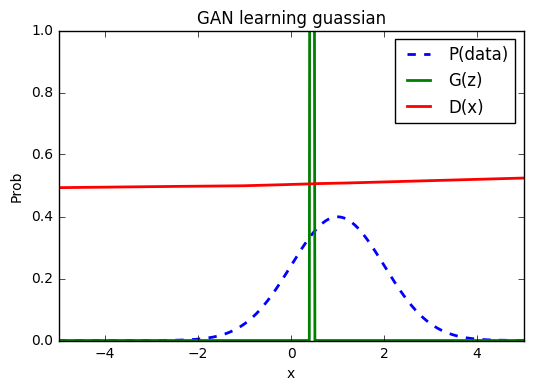

10


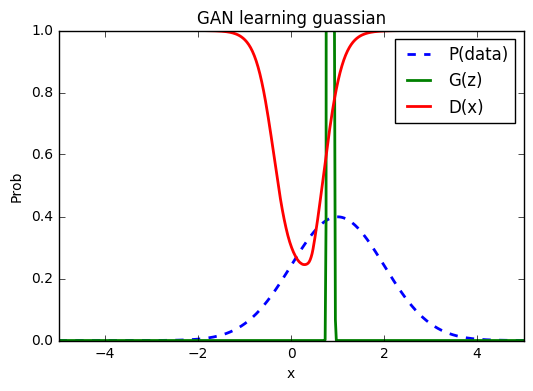

20


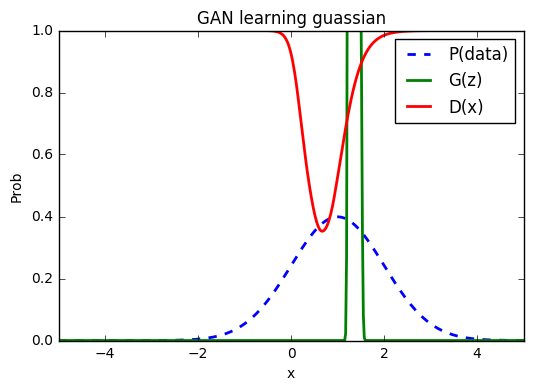

30


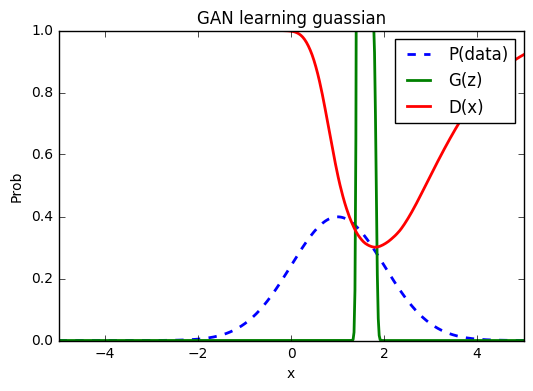

40


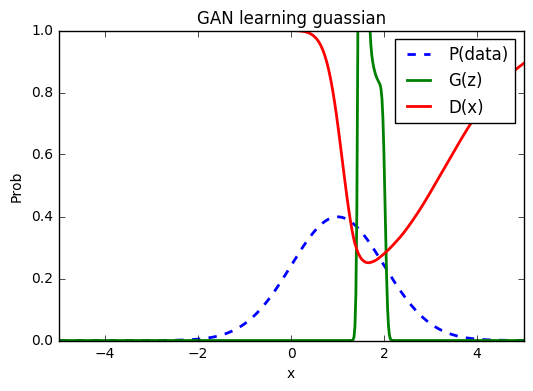

50


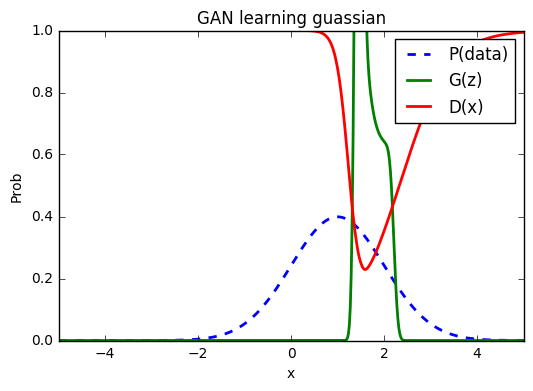

60


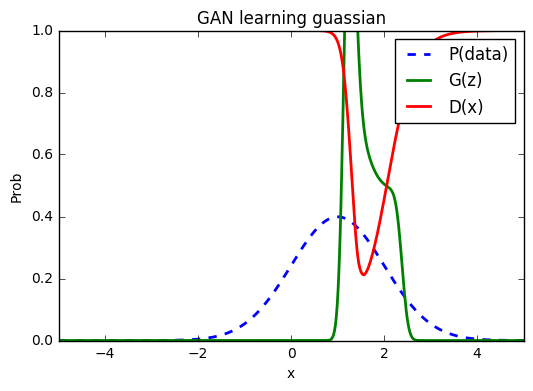

70


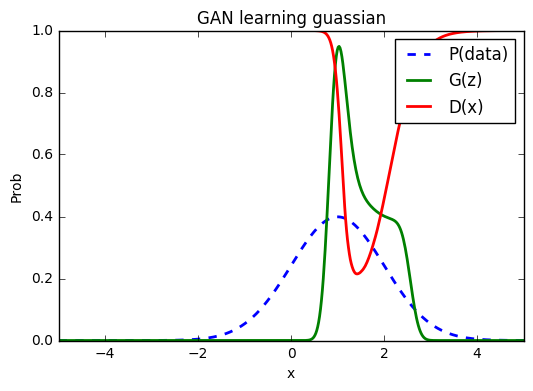

80


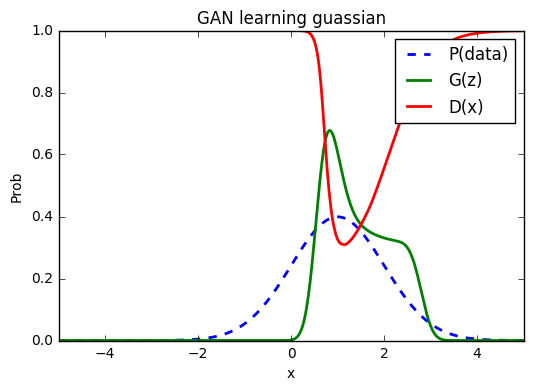

90


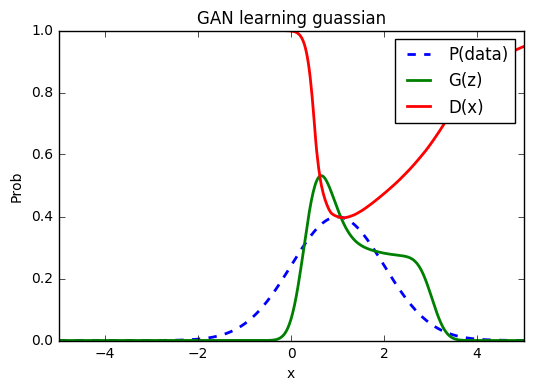

100


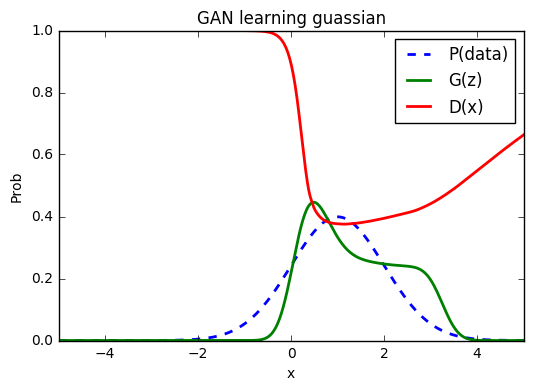

110


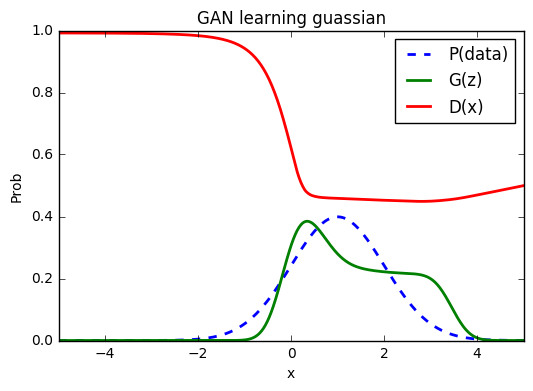

120


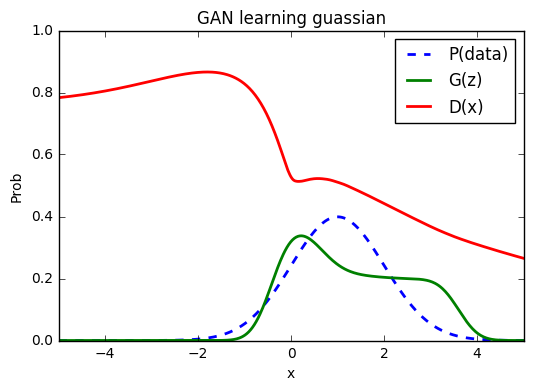

130


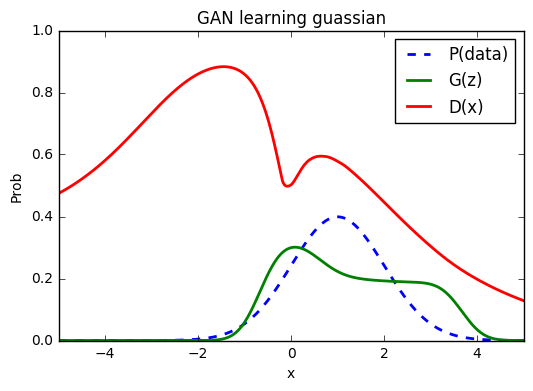

140


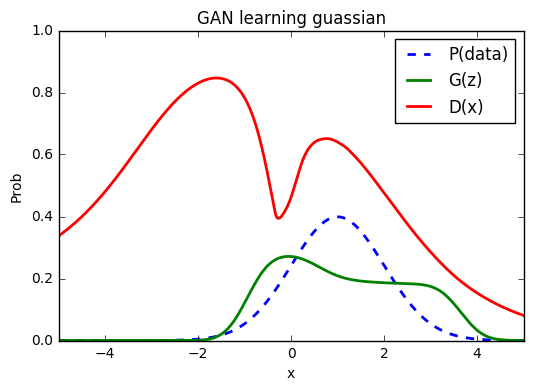

In [66]:
for i in range(150):
    #get the uniform distribution of both networks
    zmb = np.random.uniform(-1, 1, size=(batch_size, 1)).astype('float32')
    xmb = np.random.normal(1., 1, size=(batch_size, 1)).astype('float32')
    if i % 10 == 0:
        _train_g(xmb, zmb)
    else:
        _train_d(xmb, zmb)
    if i % 10 == 0:
        print i
        visualize(i)
    lrt.set_value(floatX(lrt.get_value()*0.9999))